# Deep Learning: GAN: Monet Painting
**Thomas Bohn**   --   **2025-09-22**

--  [Main Report](https://github.com/TOM-BOHN/MsDS-deep-learing-gan-monet-painting/blob/main/deep-learing-gan-monet-painting.ipynb)  --  [Github Repo](https://github.com/TOM-BOHN/MsDS-deep-learing-gan-monet-painting/tree/main)  --

# 1.&nbsp;Introduction

**Problem Statement**

The challenge is to build a Generative Adversarial Network (GAN) that can transform regular photographs into Monet-style paintings. This involves creating a system that can learn and replicate the distinctive artistic style of Claude Monet, including his unique color choices, brush strokes, and overall aesthetic. The goal is to generate 7,000 to 10,000 Monet-style images that are convincing enough to potentially fool classifiers into believing they are authentic Monet paintings.

**Why is it Important?**

This project demonstrates the intersection of art and artificial intelligence, showing how machine learning can be used to understand and replicate artistic styles. Beyond the technical challenge, this work has implications for art education, digital art creation, and our understanding of how AI can learn aesthetic principles. It also serves as a practical application of GANs in the domain of style transfer and image generation, which has applications in entertainment, education, and creative industries.

**Limitations of Existing Solutions**

Traditional style transfer methods often produce results that lack the nuanced artistic qualities of the target style. Many existing approaches struggle with maintaining the distinctive characteristics that make an artist's work recognizable, such as Monet's impressionistic brushwork and color palette. Additionally, most solutions require paired training data or produce artifacts that make the generated images look artificial rather than artistically authentic.

**Contribution**

This project implements a CycleGAN architecture to create a bidirectional mapping between the domain of regular photographs and Monet-style paintings. The approach uses unpaired training data, making it more practical than methods requiring exact correspondences between input and output images. The model learns to preserve the essential content of photographs while transforming their style to match Monet's artistic characteristics, creating convincing artistic renditions.

**DataSet**

The dataset consists of two main collections: 300 Monet paintings (256x256 pixels) and 7,028 regular photographs (256x256 pixels), both available in JPEG and TFRecord formats. The Monet paintings serve as the target style reference, while the photographs provide the source content for transformation. The dataset is designed to train a GAN that can learn the stylistic differences between these two domains and generate Monet-style versions of the input photographs.


## Python Libraries

The following python libraries are used in this notebook.

In [1]:
# File system manangement
import time, datetime, psutil, os
import shutil
import zipfile
from google.colab import userdata
from google.colab import files

# Data manipulation
import numpy as np
import pandas as pd
import math

# Install text storage and manipulation
import re
import json
import pickle
import textwrap

#Install Image processing
from PIL import Image

##################################

# Plotting and visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_theme()

# Train-test split and cross validation
from sklearn.model_selection import train_test_split, ParameterGrid

# Model evaluation
from sklearn import metrics
from sklearn.metrics import accuracy_score

#################################

# Mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#################################

# Import Tensor Flow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# this package was discontinued
# tf.keras.FUNCTION should replace tfa
#import tensorflow_addons as tfa

if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    from kaggle_datasets import KaggleDatasets

#################################

## Connect to TPUs

In [7]:
# TPU (Tensor Processing Unit) Setup for Accelerated Training
# This code attempts to connect to Google's TPU infrastructure for faster model training
# TPUs are specialized hardware designed specifically for machine learning workloads

try:
    # Try to detect and connect to a TPU cluster
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())  # Print the TPU master address

    # Connect to the TPU cluster
    tf.config.experimental_connect_to_cluster(tpu)

    # Initialize the TPU system for use
    tf.tpu.experimental.initialize_tpu_system(tpu)

    # Create a TPU distribution strategy for multi-core TPU usage
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

except:
    # Fallback: If TPU is not available, use the default strategy (CPU/GPU)
    # This ensures the code works in environments without TPU access
    strategy = tf.distribute.get_strategy()

# Print the number of replicas (cores) available for parallel processing
print('Number of replicas:', strategy.num_replicas_in_sync)

# Set up automatic tuning for data pipeline performance optimization
# AUTOTUNE allows TensorFlow to automatically determine the optimal number of parallel calls
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Print TensorFlow version for reference
print(tf.__version__)

Number of replicas: 1
2.19.0


## Global Variables

The following are global variables referenced in this notebook.

In [8]:
# Recording the starting time, complemented with a stopping time check in the end to compute process runtime
start = time.time()

# Class representing the OS process and having memory_info() method to compute process memory usage
process = psutil.Process(os.getpid())

In [10]:
# Global Debug flag used to turn on and off more chatty blocks of code
gDEBUG = True
if gDEBUG: print('Debug is set to:', gDEBUG)
# Global Level of Detail of table stats and details
gLOD = 2
print('Level of Detail for functions is set to:', gLOD)

Debug is set to: True
Level of Detail for functions is set to: 2


# 2.&nbsp;Data Source

This section handles dataset loading and preparation for the CycleGAN model. The code automatically detects the execution environment (Kaggle, Google Colab, or local) and loads the appropriate dataset files. For Kaggle, it accesses the competition datasets through Google Cloud Storage. For Colab, it mounts Google Drive and extracts the dataset files locally. The datasets consist of Monet paintings and regular photos, which will be used to train the bidirectional image translation model.

## Import the Data (Kaggle or Colab)

This section loads the dataset file paths for both photo and Monet painting collections. The datasets are kept separate to maintain clear domain boundaries for the CycleGAN training process. We'll load the TFRecord filenames first, then process the actual image data in subsequent steps.

In [12]:
print('os.environ: ', os.environ)

if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    print("Detected Kaggle environment - using Kaggle datasets")
elif 'COLAB_GPU' in os.environ or 'COLAB_TPU' in os.environ or 'COLAB_CPU' in os.environ:
    print("Detected Google Colab environment - using local datasets")
else:
    print("YIKES! I don't know where I am !!!!!!")

os.environ:  environ({'SHELL': '/bin/bash', 'NV_LIBCUBLAS_VERSION': '12.5.3.2-1', 'NVIDIA_VISIBLE_DEVICES': 'all', 'COLAB_JUPYTER_TRANSPORT': 'ipc', 'NV_NVML_DEV_VERSION': '12.5.82-1', 'NV_CUDNN_PACKAGE_NAME': 'libcudnn9-cuda-12', 'CGROUP_MEMORY_EVENTS': '/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events', 'NV_LIBNCCL_DEV_PACKAGE': 'libnccl-dev=2.22.3-1+cuda12.5', 'NV_LIBNCCL_DEV_PACKAGE_VERSION': '2.22.3-1', 'VM_GCE_METADATA_HOST': '169.254.169.253', 'MODEL_PROXY_HOST': 'https://mp.kaggle.net', 'HOSTNAME': '4a82d8e4eb4a', 'LANGUAGE': 'en_US', 'TBE_RUNTIME_ADDR': '172.28.0.1:8011', 'COLAB_TPU_1VM': '', 'GCE_METADATA_TIMEOUT': '3', 'NVIDIA_REQUIRE_CUDA': 'cuda>=12.5 brand=unknown,driver>=470,driver<471 brand=grid,driver>=470,driver<471 brand=tesla,driver>=470,driver<471 brand=nvidia,driver>=470,driver<471 brand=quadro,driver>=470,driver<471 brand=quadrortx,driver>=470,driver<471 brand=nvidiartx,driver>=470,driver<471 brand=vapps,driver>=470,driver<471 brand=v

In [19]:
# Environment Detection and Dataset Loading
# Detect whether we're running in Kaggle or Google Colab and load datasets accordingly

# Check if we're in Kaggle environment
if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    print("Detected Kaggle environment - using Kaggle datasets")

    # Dataset Path Configuration for Kaggle Environment
    # Get the Google Cloud Storage (GCS) path for Kaggle datasets
    # This allows access to the competition datasets stored in Kaggle's cloud storage
    GCS_PATH = KaggleDatasets().get_gcs_path()

    # Load Monet Painting Dataset
    # Search for all TFRecord files containing Monet paintings in the monet_tfrec directory
    # TFRecord is TensorFlow's efficient binary format for storing large datasets
    MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
    print('Monet TFRecord Files:', len(MONET_FILENAMES))

    # Load Photo Dataset
    # Search for all TFRecord files containing regular photos in the photo_tfrec directory
    # These photos will be transformed into Monet-style paintings by the GAN
    PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
    print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

elif 'COLAB_GPU' in os.environ or 'COLAB_TPU' in os.environ or 'COLAB_CPU' in os.environ:
    print("Detected Google Colab environment - using local datasets")

    # Define the source of the zipped data files
    target_file = 'gan-getting-started.zip'
    source_path_root = '/content/drive/MyDrive/[1.4] MsDS Class Files/-- DTSA 5511 Deep Learning/data'
    destination_path_root = '/content'

    # Copy the files to the runtime
    shutil.copy(source_path_root + '/' + target_file, destination_path_root + '/')

    # Display the files in the destination directory
    print('Files in destination directory:', os.listdir(destination_path_root + '/'))

    # Unzip the files (this is slow)
    zip_file_path = destination_path_root + '/' + target_file

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all the contents into the specified folder
        zip_ref.extractall(destination_path_root + '/' + 'gan_getting_started')

    print('Dataset extraction completed')

    # Dataset Path Configuration for Google Colab Environment
    # Set up local file paths for the extracted dataset files
    # This replicates the Kaggle GCS_PATH functionality for local Colab environment
    COLAB_DATA_PATH = '/content/gan_getting_started'

    # Load Monet Painting Dataset (Colab Version)
    # Search for all TFRecord files containing Monet paintings in the monet_tfrec directory
    # Using os.path.join for cross-platform compatibility
    MONET_FILENAMES = tf.io.gfile.glob(os.path.join(COLAB_DATA_PATH, 'monet_tfrec', '*.tfrec'))
    print('Monet TFRecord Files:', len(MONET_FILENAMES))

    # Load Photo Dataset (Colab Version)
    # Search for all TFRecord files containing regular photos in the photo_tfrec directory
    # These photos will be transformed into Monet-style paintings by the GAN
    PHOTO_FILENAMES = tf.io.gfile.glob(os.path.join(COLAB_DATA_PATH, 'photo_tfrec', '*.tfrec'))
    print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

else:
    print("Detected local environment - please ensure datasets are available")
    # Fallback for local development - you can customize this path
    LOCAL_DATA_PATH = './data'  # Adjust this path as needed

    MONET_FILENAMES = tf.io.gfile.glob(os.path.join(LOCAL_DATA_PATH, 'monet_tfrec', '*.tfrec'))
    PHOTO_FILENAMES = tf.io.gfile.glob(os.path.join(LOCAL_DATA_PATH, 'photo_tfrec', '*.tfrec'))

    print('Monet TFRecord Files:', len(MONET_FILENAMES))
    print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

# Verify the datasets are loaded correctly
if len(MONET_FILENAMES) > 0:
    print(f"Successfully loaded {len(MONET_FILENAMES)} Monet painting files")
    if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
        print(f"First Monet file: {MONET_FILENAMES[0]}")
else:
    print("No Monet files found. Check the dataset path.")

if len(PHOTO_FILENAMES) > 0:
    print(f"Successfully loaded {len(PHOTO_FILENAMES)} photo files")
    if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
        print(f"First photo file: {PHOTO_FILENAMES[0]}")
else:
    print("No photo files found. Check the dataset path.")

Detected Google Colab environment - using local datasets
Files in destination directory: ['.config', 'monet_tfrec', 'photo_tfrec', 'gan-getting-started', 'photo_jpg', 'monet_jpg', 'gan-getting-started.zip', 'drive', 'sample_data']
Dataset extraction completed
Monet TFRecord Files: 5
Photo TFRecord Files: 20
Successfully loaded 5 Monet painting files
Successfully loaded 20 photo files


## Load the Datasets

All the images for the competition are already sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale. Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord. Finally, we define the function to extract the image from the files.

In [20]:
# Image Processing Configuration
# Define the target image size for the GAN model
IMAGE_SIZE = [256, 256]

def decode_image(image):
    # Decode the JPEG image data into a tensor with 3 color channels (RGB)
    image = tf.image.decode_jpeg(image, channels=3)
    # Normalize pixel values from [0, 255] to [-1, 1] range
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    # Reshape to the target image size with 3 color channels
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    # Define the expected structure of each TFRecord entry
    # This matches the format used in the Kaggle competition dataset
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),  # Filename as string
        "image": tf.io.FixedLenFeature([], tf.string),       # Image data as bytes
        "target": tf.io.FixedLenFeature([], tf.string)       # Target label as string
    }
    # Parse the TFRecord example according to the defined format
    example = tf.io.parse_single_example(example, tfrecord_format)
    # Extract and decode the image data
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    # Create a TFRecord dataset from the provided filenames
    dataset = tf.data.TFRecordDataset(filenames)
    # Apply the read_tfrecord function to each example in parallel
    # AUTOTUNE allows TensorFlow to automatically determine optimal parallelism
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [21]:
# Load in datasets.
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

# 3.&nbsp;Exploratory Data Analysis (EDA)

The EDA phase focuses on understanding the dataset, including data distribution and label counts. Additional a visual display of the images for the model are previewed to better understand the problem in scope.

## EDA Analysis: Image Preview

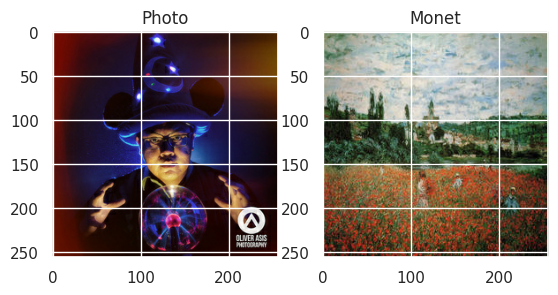

In [22]:
# Get a sample image
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

# Visualize a photo example and a Monet example.
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

## EDA Results

ADD HERE

# 4.&nbsp; Image Preprocessing

##  Upsample and Downsample Functions

Our CycleGAN generator uses a **U-Net architecture** with encoder-decoder blocks. The **downsampling function** reduces spatial dimensions (width and height) while increasing feature channels using `Conv2D` with `stride=2`, which moves the filter 2 pixels at a time to halve the image resolution (256×256 → 128×128 → ... → 1×1). The **upsampling function** does the opposite, using `Conv2DTranspose` with `stride=2` to double the dimensions and reconstruct higher-resolution images from lower-resolution feature maps (1×1 → 2×2 → ... → 256×256).

We use **instance normalization** instead of batch normalization because it's more effective for GAN training and style transfer tasks. It normalizes each feature map independently across spatial dimensions, providing better training stability. Since instance normalization isn't part of the standard TensorFlow API, we implement it using TensorFlow Add-ons.

The U-Net architecture includes **skip connections** that preserve fine-grained details during upsampling by connecting corresponding encoder and decoder layers. This enables the generator to produce high-quality, detailed images by combining both low-level and high-level features.

In [ ]:
# Output Configuration
# Number of channels in the final generated image (RGB = 3 channels)
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    # Weight initialization for stable training
    # Xavier-like initialization with small standard deviation
    initializer = tf.random_normal_initializer(0., 0.02)

    # Build the downsampling block as a sequential model
    result = keras.Sequential()

    # CONVOLUTIONAL LAYER
    # Conv2D with stride=2 reduces spatial dimensions by half
    # use_bias=False because we use instance normalization
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    # INSTANCE NORMALIZATION (Optional)
    # Instance normalization helps with training stability in GANs
    # It normalizes each feature map independently (unlike batch norm)
    # This is particularly effective for style transfer tasks
    if apply_instancenorm:
        result.add(layers.LayerNormalization(axis=[1, 2], epsilon=1e-5))

    # ACTIVATION FUNCTION
    # LeakyReLU allows small negative values, helping with gradient flow
    # This is preferred over ReLU in GAN discriminators and some generator parts
    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    # Weight initialization for stable training
    # Same initialization as downsample for consistency
    initializer = tf.random_normal_initializer(0., 0.02)

    # Build the upsampling block as a sequential model
    result = keras.Sequential()

    # TRANSPOSE CONVOLUTIONAL LAYER
    # Conv2DTranspose with stride=2 doubles the spatial dimensions
    # This is the inverse operation of Conv2D with stride=2
    # use_bias=False because we use instance normalization
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    # INSTANCE NORMALIZATION
    # Always applied in upsampling blocks for training stability
    # Helps maintain consistent feature distributions during reconstruction
    result.add(layers.LayerNormalization(axis=[1, 2], epsilon=1e-5))

    # DROPOUT (Optional)
    # Applied to early upsampling layers to prevent overfitting
    # Helps the model generalize better during training
    if apply_dropout:
        result.add(layers.Dropout(0.5))

    # ACTIVATION FUNCTION
    # ReLU for upsampling blocks (different from LeakyReLU in downsample)
    # ReLU helps with gradient flow during the reconstruction process
    result.add(layers.ReLU())

    return result

## Build The Generators

The generator uses an encoder-decoder architecture where it first downsamples the input image to extract abstract features, then upsamples these features back to the original resolution. **Skip connections** bridge the encoder and decoder by directly connecting corresponding layers at the same resolution level. These connections help preserve fine-grained spatial details that would otherwise be lost during downsampling, enabling the generator to produce high-quality images with both global structure and local details. The skip connections also improve gradient flow during training, helping the model learn more effectively.

In [25]:
def Generator():
    # Input layer: expects RGB images of size 256x256
    inputs = layers.Input(shape=[256,256,3])

    # ENCODER STACK (Downsampling Path)
    # Progressively reduces spatial dimensions while increasing feature channels
    # Each layer halves the image size and doubles the channels (except first layer)
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)  - No instance norm on first layer
        downsample(128, 4), # (bs, 64, 64, 128)      - Extract mid-level features
        downsample(256, 4), # (bs, 32, 32, 256)      - Extract high-level features
        downsample(512, 4), # (bs, 16, 16, 512)      - Extract semantic features
        downsample(512, 4), # (bs, 8, 8, 512)        - Continue feature extraction
        downsample(512, 4), # (bs, 4, 4, 512)        - High-level semantic features
        downsample(512, 4), # (bs, 2, 2, 512)        - Very high-level features
        downsample(512, 4), # (bs, 1, 1, 512)        - Bottleneck: most abstract features
    ]

    # DECODER STACK (Upsampling Path)
    # Progressively increases spatial dimensions while decreasing feature channels
    # Dropout is applied to first 3 layers to prevent overfitting during training
    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)   - Start reconstruction with dropout
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)   - Continue with dropout
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)   - Continue with dropout
        upsample(512, 4), # (bs, 16, 16, 1024)       - No dropout for stability
        upsample(256, 4), # (bs, 32, 32, 512)        - Reduce channels, increase resolution
        upsample(128, 4), # (bs, 64, 64, 256)        - Continue upsampling
        upsample(64, 4), # (bs, 128, 128, 128)       - Final upsampling layer
    ]

    # FINAL OUTPUT LAYER
    # Converts features back to RGB image with tanh activation for [-1,1] range
    initializer = tf.random_normal_initializer(0., 0.02)  # Xavier-like initialization
    last = layers.Conv2DTranspose(
        OUTPUT_CHANNELS,  # 3 channels for RGB output
        4,                # 4x4 kernel size
        strides=2,        # Double the spatial dimensions
        padding='same',   # Maintain spatial dimensions
        kernel_initializer=initializer,  # Weight initialization
        activation='tanh' # Output in [-1, 1] range (standard for GANs)
    ) # Final output: (bs, 256, 256, 3)

    # FORWARD PASS IMPLEMENTATION
    x = inputs

    # ENCODER: Downsampling with skip connection collection
    # Store intermediate features for skip connections (U-Net architecture)
    skips = []
    for down in down_stack:
        x = down(x)           # Apply downsampling layer
        skips.append(x)       # Store feature map for skip connection

    # Prepare skip connections for decoder (reverse order, exclude bottleneck)
    skips = reversed(skips[:-1])  # Skip the final 1x1 bottleneck layer

    # DECODER: Upsampling with skip connections
    # Combine upsampled features with corresponding encoder features
    for up, skip in zip(up_stack, skips):
        x = up(x)                                    # Upsample features
        x = layers.Concatenate()([x, skip])          # Add skip connection (concatenate)

    # Generate final output image
    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

## Build the Discriminator

The discriminator takes in the input image and classifies it as real or fake (generated). Instead of outputing a single node, the discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.

In [ ]:
def Discriminator():
    # Weight initialization for stable training
    # Same initialization as generator for consistency
    initializer = tf.random_normal_initializer(0., 0.02)

    # Input layer: expects RGB images of size 256x256
    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    # FEATURE EXTRACTION LAYERS (Downsampling)
    # Progressively reduce spatial dimensions while increasing feature channels
    # First layer: No instance normalization (common practice for discriminators)
    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)  - Extract low-level features
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)     - Extract mid-level features
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)     - Extract high-level features

    # FINAL CONVOLUTIONAL BLOCK
    # Add zero padding to maintain spatial dimensions for the final conv layers
    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256) - Add 1 pixel padding on all sides

    # Convolutional layer with stride=1 (no spatial reduction)
    # 512 filters to extract the most abstract features
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    # Instance normalization for training stability
    norm1 = layers.LayerNormalization(axis=[1, 2], epsilon=1e-5)(conv)

    # LeakyReLU activation (standard for discriminators)
    leaky_relu = layers.LeakyReLU()(norm1)

    # OUTPUT LAYER PREPARATION
    # Add zero padding for the final output layer
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512) - Add 1 pixel padding

    # FINAL OUTPUT LAYER
    # Single channel output (1 filter) for real/fake classification
    # Each pixel in the output represents a patch classification
    # No activation function - raw logits for loss calculation
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

## Initialize CycleGAN Models

This section creates the four core models that make up the CycleGAN architecture: two generators for bidirectional image translation and two discriminators for domain-specific quality control. All models are initialized within the TPU/GPU strategy scope to ensure optimal performance across available hardware resources.

In [27]:
# Initialize CycleGAN Models within TPU/GPU Strategy Scope
# The strategy.scope() ensures all models are distributed across available hardware (TPU cores or GPUs)
with strategy.scope():
    # GENERATOR MODELS (Image-to-Image Translation)
    # Two generators create a bidirectional mapping between photo and Monet domains

    monet_generator = Generator()  # Photo → Monet: Transforms regular photos into Monet-style paintings
    photo_generator = Generator()  # Monet → Photo: Transforms Monet paintings into realistic photos

    # DISCRIMINATOR MODELS (Real vs Fake Classification)
    # Two discriminators ensure each generator produces convincing results in their target domain

    monet_discriminator = Discriminator()  # Monet Domain: Distinguishes real Monet paintings from generated ones
    photo_discriminator = Discriminator()  # Photo Domain: Distinguishes real photos from generated ones

AttributeError: module 'keras._tf_keras.keras.layers' has no attribute 'InstanceNormalization'

## Test the Generator

This section demonstrates the generator's transformation capability before training. Since our generators are not trained yet, the generated Monet-esque photo will not show the expected artistic style at this point. This provides a baseline to compare against the trained model's output later.

In [ ]:
# Generate Monet-style painting from example photo
to_monet = monet_generator(example_photo)

# Create side-by-side comparison visualization
# Subplot 1: Display the original input photo
plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

# Subplot 2: Display the generated Monet-style painting
plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)

# Display the comparison plot
plt.show()

## Test Split Analysis

In [ ]:
{{xxxxx}}

# 5.&nbsp;Data Cleansing & Text Normalization

{{xxxxx}}

## Core Normalization Functions

In [ ]:
{{xxxxx}}

## Apply Text Normalization

In [ ]:
{{xxxxx}}

# 6.&nbsp;Feature Engineering with TF-IDF

The TfidfVectorizer from scikit-learn is used to convert the text documents into numerical features. The vectorizer transforms the collection of documents into a matrix of token counts, which is then normalized using the Term Frequency-Inverse Document Frequency (TF-IDF) transformation. This matrix representation of the text data serves as input to the machine learning models.

## TF_IDF Functions

In [ ]:
{{xxxxx}}

## Vectorization

In [ ]:
{{xxxxx}}

# 7.&nbsp; Baseline Models: Supervised

## Model Functions

In [ ]:
{{xxxxx}}

## Build, Train, and Evaluate the Model

In [ ]:
{{xxxxx}}

# 8.&nbsp; Hyperparameter Tuning

## Tuning Functions

In [ ]:
{{xxxxx}}

## Execute Hyperparameter Tuning

In [ ]:
{{xxxxx}}

# 9.&nbsp;Final Prediction and Evaluation

## Evaluation Functions

In [ ]:
{{xxxxx}}

## Train the Final Model

In [ ]:
{{xxxxx}}

## Evaluate the Model

In [ ]:
{{xxxxx}}

## Explore Errors

In [ ]:
{{xxxxx}}

# 10.&nbsp;Scale the Auto-Classifier

## Auto-Classifier Functions

In [ ]:
{{xxxxx}}

## Rerun Process for L1

In [ ]:
{{xxxxx}}

## Rerun Process for L2

In [ ]:
{{xxxxx}}

# 11.&nbsp; Conclusions

{{xxxxx}}

## Results Summary

### Model Result Summary


**Baseline Results**

{{xxxxx}}

**Hyperparameter Tuning Results**

{{xxxxx}}

**Best Model Results**

{{xxxxx}}

**Best Model Performance**

{{xxxxx}}

## Model Comparison

### Model Comparisons and Findings

{{xxxxx}}

#### Baseline Results

{{xxxxx}}

#### Hyperparameter Tuning

{{xxxxx}}

#### Best Model Results

{{xxxxx}}

#### Performance Breakdown (Best Model)

{{xxxxx}}

#### Conclusion

{{xxxxx}}

## Concluding Observations

## Patterns and Conclusions Across the Models

{{xxxxx}}

# 12.&nbsp; References

**Kaggle Competition**

- [1] Amy Jang, Ana Sofia Uzsoy, and Phil Culliton. I’m Something of a Painter Myself. https://kaggle.com/competitions/gan-getting-started, 2020. Kaggle.

**Documentation and References**

- [2] Kaggle. Monet CycleGAN Tutorial. Amy Jang. 2020. https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial
- [3] Kaggle. Week 5 GAN Mini-Project - Final Execution. Ryan Lynch. 2025. https://www.kaggle.com/code/lynchrl/week-5-gan-mini-project-final-execution

**Library Documentation**

- [4] https://keras.io/examples/generative/cyclegan/
- [5] https://www.tensorflow.org/api_docs/python/tf/data/Dataset
- [6] https://www.tensorflow.org/guide/autodiff
